In [245]:
from sklearn import datasets 
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

#### Tratamento dos dados

In [520]:
# Carrega os dados

breast_cancer = datasets.load_breast_cancer()
X = pd.DataFrame(breast_cancer.data)
y = breast_cancer.target

print(breast_cancer.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

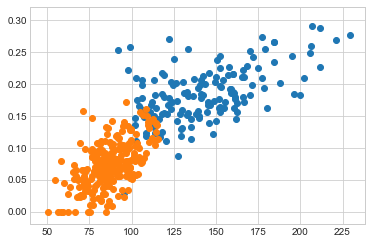

In [521]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

# Divide os dados em treino e teste (30/70)
xtrain,xtest,ytrain,ytest = train_test_split(X.values,y,train_size=0.7)
scaler = MinMaxScaler()

# Normaliza os dados
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled =  scaler.fit_transform(xtest)

# Visualiza os dados
selector = SelectKBest(k=2)
selected_rows = selector.fit_transform(xtrain,ytrain)

plt.scatter(selected_rows[ytrain==0,0],selected_rows[ytrain==0,1])
plt.scatter(selected_rows[ytrain==1,0],selected_rows[ytrain==1,1])
selected_idx = np.where(selector.get_support())


#### Seleção de features

In [497]:
# Seleciona o número ideal de features através significância estatística

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

def select_feat(xtrain,ytrain,k):    
    # Seleciona as k features mais importantes
    
    selector = SelectKBest(k=k) 
    selected_rows = selector.fit_transform(xtrain,ytrain)    
    return selected_rows,selector.get_support()

def select_best_features(xtrain,ytrain):
    # Faz crosvalidação para estimar avaliar acurácia usando k features
    kfold = KFold(n_splits=5,shuffle=True,random_state=10) 
    ks = range(1,X.shape[1]) #Faz um range de features
    svm = SVC(kernel='rbf') #Instacia um classificador  SMV
    scores = [] #Lista para armazenar as acurácias

    for k in ks:# Para cada k
        cv_score = 0
        selected_rows,supp = select_feat(xtrain,ytrain,k)
        
        # Percorre os folds
        for train_index,test_index in kfold.split(X=selected_rows,y=ytrain): 
            # Faz o split dos dados em treino e teste
            xval_train,xval_test = selected_rows[train_index],selected_rows[test_index]  
            yval_train,yval_test = ytrain[train_index],ytrain[test_index] #                     
            # Aplica o classificador nos dados de treino
            svm.fit(xval_train,yval_train)
            # Calcula acurácia do modelo no set de validação
            cv_score += svm.score(xval_test,yval_test)
        
        # Calcula a média dos scores dos dados de validação   
        scores.append(cv_score/5)     
    # Seleciona o valor de k que tem a maior acurária média
    best_k = np.argmax(scores)    
    return best_k


#### Modelagem

In [510]:
import seaborn.apionly as sns
sns.set_style('whitegrid')

# Define uma função para plotar as curvas de decisão
def plot_decision_bound(model,x,y,ax,poly=None,poly_degree=3):
    # intervalos para os os vetores
    offset = .3
    min0 = np.min(x[:,0]) - offset
    max0 = np.max(x[:,0]) + offset
    interval0 = np.arange(min0,max0,(max0-min0)/300)
    n0 = interval0.shape[0]
    min1 = np.min(x[:,1])-offset
    max1 = np.max(x[:,1])+offset
    interval1 = np.arange(min1,max1,(max1-min1)/300)
    n1 = interval1.shape[0]
    
    # cria um mesh com os intervalos 
    x0,x1 = np.meshgrid(interval0,interval1)
    x0 = x0.reshape(-1,1)
    x1 = x1.reshape(-1,1)
    
    #concatena os vetores
    xx = np.concatenate((x0,x1),axis=1)
    
    if poly!=None:
        xx = PolynomialFeatures(degree=poly_degree,include_bias=False).fit_transform(xx)
    
    # Faz a predição
    yy = model.predict(xx)
    yy = yy.reshape(n0,n1)
    x0 = x0.reshape(n0,n1)
    x1 = x1.reshape(n0,n1)
    
    # plota a curva de decisão e dos vetores originais
    ax.contourf(x0,x1,yy,cmap=plt.cm.coolwarm_r,alpha=0.3)
    ax.scatter(x[y==0,0],x[y==0,1],alpha=0.4)
    ax.scatter(x[y==1,0],x[y==1,1],alpha=0.4)        

In [522]:
# Treino os dados em diferentes classificadores

from sklearn.model_selection import GridSearchCV
Cvals = [10**i for i in range(-3,4)]

# Seleciona k preditores que estão fortemente relacionados a variável dependente
selector = SelectKBest(k=2)
selected_rows,support = select_feat(xtrain_scaled,ytrain,2)
new_xtest = xtest_scaled[:,support]    

# Treina um classificador SVM

param_grid = {'C':Cvals,'gamma':Cvals}
grid_svm = GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,cv=10)
grid_svm.fit(selected_rows,ytrain)

# Treina um classificador knn

grid_knn = GridSearchCV(KNeighborsClassifier(),param_grid={'n_neighbors':range(1,10)},cv=5)
grid_knn.fit(selected_rows,ytrain)
grid_knn.score(selected_rows,ytrain)

#Treina um classificador LogisticRegression

logreg = GridSearchCV(LogisticRegression(),param_grid={'C':Cvals},cv=5)
logreg.fit(selected_rows,ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)




Curvas obtidas por modelos que foram treinados apenas com os 2 principais preditores.


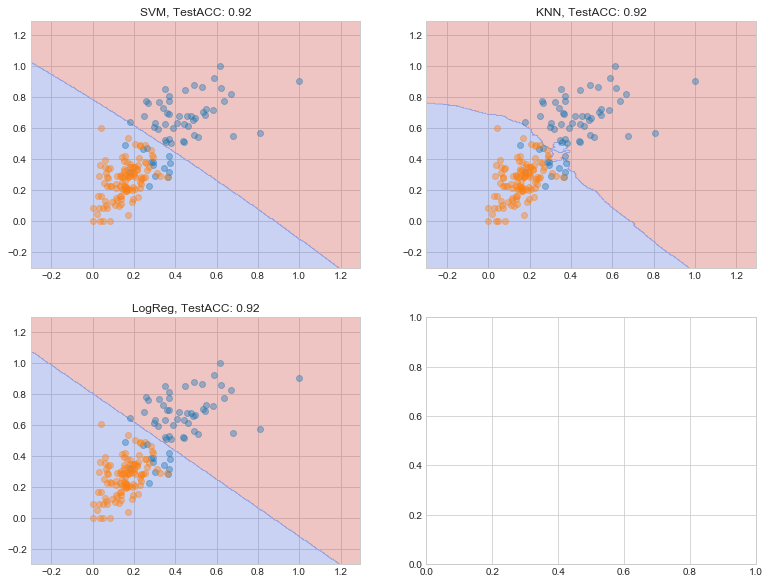

In [523]:
# plota as curvas de decisão 

fig,axs = plt.subplots(2,2,figsize=(13,10))
axs[0,0].set_title('SVM, TestACC: {:.2f}'.format(grid_svm.score(new_xtest,ytest)))
axs[0,1].set_title('KNN, TestACC: {:.2f}'.format(grid_knn.score(new_xtest,ytest)))
axs[1,0].set_title('LogReg, TestACC: {:.2f}'.format(logreg.score(new_xtest,ytest)))
print('\n\n')
print('Curvas obtidas por modelos que foram treinados apenas com os 2 principais preditores.')
plot_decision_bound(model=grid_svm,x=new_xtest,y=ytest,ax=axs[0,0])
plot_decision_bound(model=grid_knn,x=new_xtest,y=ytest,ax=axs[0,1])
plot_decision_bound(model=logreg,x=new_xtest,y=ytest,ax=axs[1,0])

#### Seleção de features com PCA e RBF

In [524]:
# Treina um clasificador SVM com features extraídas por PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xtrain_pca_scaled = pca.fit_transform(xtrain_scaled)
xtest_pca_scaled = pca.transform(xtest_scaled)

param_grid = {'C':Cvals,'gamma':Cvals}
grid = GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,cv=5)
grid.fit(xtrain_pca_scaled,ytrain)


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)



 Curvas obtidas por um classificador SVM com base nas duas principais componentes dos dados.


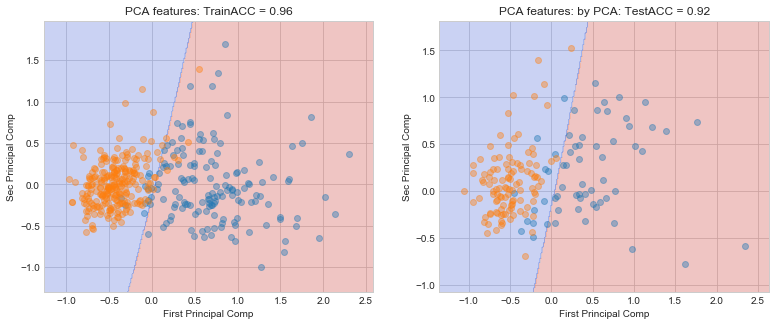

In [525]:
# Visualiza as curvas de contorno

fig,axs = plt.subplots(1,2,figsize=(13,5))
print('\n\n Curvas obtidas por um classificador SVM com base nas duas principais componentes dos dados.')
plot_decision_bound(model=grid,x=xtrain_pca_scaled,y=ytrain,ax=axs[0])      
plot_decision_bound(model=grid,x=xtest_pca_scaled,y=ytest,ax=axs[1])  

axs[0].set_title('PCA features: TrainACC = {:.2f}'.format(grid.score(xtrain_pca_scaled,ytrain)))
axs[1].set_title('PCA features: by PCA: TestACC = {:.2f}'.format(grid.score(xtest_pca_scaled,ytest)))
axs[0].set_xlabel('First Principal Comp')
axs[0].set_ylabel('Sec Principal Comp')
axs[1].set_xlabel('First Principal Comp')
axs[1].set_ylabel('Sec Principal Comp')

In [526]:
# Seleciona os preditores usando RFE 

from sklearn.feature_selection import RFE
select = RFE(LogisticRegression(),n_features_to_select=2)
new_xtrain = select.fit_transform(xtrain_scaled,ytrain)
new_xtest = select.transform(xtest_scaled)



Curvas obtidas por um classificador SVM considerando 2 features selecionadas através de Regressão Logística.


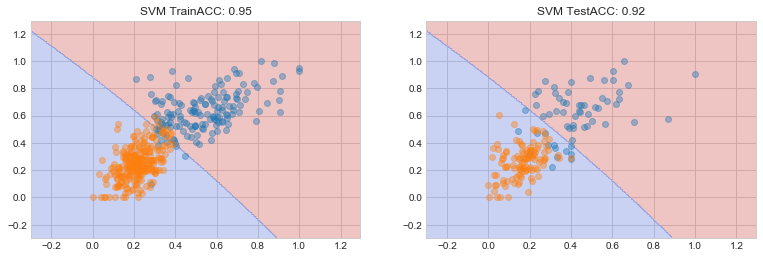

In [527]:
# Treina um classificador SVM

g = GridSearchCV(SVC(kernel='rbf'),cv=10,param_grid=param_grid)
g.fit(new_xtrain,ytrain)
fig,axs = plt.subplots(1,2,figsize=(13,4))

print('\n\nCurvas obtidas por um classificador SVM considerando 2 features selecionadas através de Regressão Logística.')
plot_decision_bound(ax=axs[0],model=g,x=new_xtrain,y=ytrain)
plot_decision_bound(ax=axs[1],model=g,x=new_xtest,y=ytest)
axs[0].set_title('SVM TrainACC: {:.2f}'.format(g.score(new_xtrain,ytrain)))
axs[1].set_title('SVM TestACC: {:.2f}'.format(g.score(new_xtest,ytest)))




Curvas obtidas por um classificador KNN considerando 2 features selecionadas através de Regressão Logística.


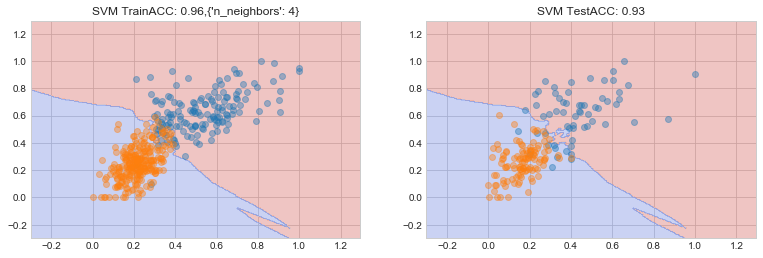

In [528]:
# Treina um KNN

g = GridSearchCV(KNeighborsClassifier(),cv=10,param_grid={'n_neighbors':range(1,25)})
g.fit(new_xtrain,ytrain)
fig,axs = plt.subplots(1,2,figsize=(13,4))
print('\n\nCurvas obtidas por um classificador KNN considerando 2 features selecionadas através de Regressão Logística.')
plot_decision_bound(ax=axs[0],model=g,x=new_xtrain,y=ytrain)
plot_decision_bound(ax=axs[1],model=g,x=new_xtest,y=ytest)
axs[0].set_title('SVM TrainACC: {:.2f},{}'.format(g.score(new_xtrain,ytrain),g.best_params_))
axs[1].set_title('SVM TestACC: {:.2f}'.format(g.score(new_xtest,ytest)))




Curvas obtidas por um classificador LogReg considerando 2 features selecionadas através de outro modelo LogReg.


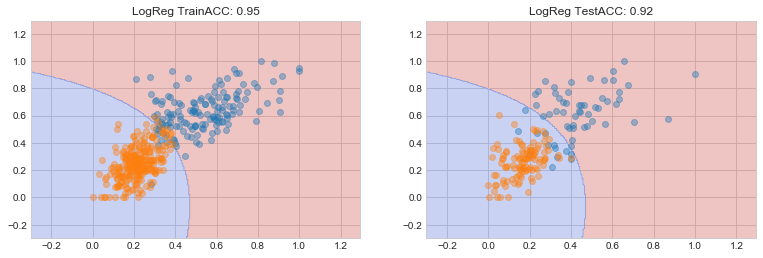

In [530]:
# Treina uma Regressão Logística

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=10,include_bias=False)

xtrain_poly = poly.fit_transform(new_xtrain)
xtest_poly = poly.transform(new_xtest)

logreg = GridSearchCV(LogisticRegression(),param_grid={'C':Cvals},cv=5)
logreg.fit(xtrain_poly,ytrain)


fig,axs = plt.subplots(1,2,figsize=(13,4))
print('\n\nCurvas obtidas por um classificador LogReg considerando 2 features selecionadas através de outro modelo LogReg.')
plot_decision_bound(ax=axs[0],model=logreg,x=xtrain_poly,y=ytrain,poly=True,poly_degree=10)
plot_decision_bound(ax=axs[1],model=logreg,x=xtest_poly,y=ytest,poly=True,poly_degree=10)
axs[0].set_title('LogReg TrainACC: {:.2f}'.format(logreg.score(xtrain_poly,ytrain)))
axs[1].set_title('LogReg TestACC: {:.2f}'.format(logreg.score(xtest_poly,ytest)))


(array([ 16.,  15.,  15.,  19.,  23.,  57.,  43.,  34.,  27.,   8.]),
 array([ 0.00718666,  0.18991402,  0.37264138,  0.55536874,  0.7380961 ,
         0.92082346,  1.10355083,  1.28627819,  1.46900555,  1.65173291,
         1.83446027]),
 <a list of 10 Patch objects>)

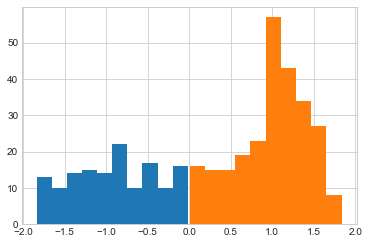

In [546]:
pred = grid_svm.predict(new_xtrain)
df = grid_svm.decision_function(new_xtrain)
plt.hist(df[pred==0])
plt.hist(df[pred==1])
#plt.yscale('log')